In [3]:
#https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6
#https://github.com/waleedka/traffic-signs-tensorflow/blob/master/notebook1.ipynbhttps://github.com/waleedka/traffic-signs-tensorflow/blob/master/notebook1.ipynb
#https://towardsdatascience.com/recognizing-traffic-signs-with-over-98-accuracy-using-deep-learning-86737aedc2ab
'''
TODO:
- set up training sets
- set testing sets
- make test.txt that uses altered stop sign pictues for testing

How this dataset works:
The Images folder contains only clean images labeled 0000000.png to 1708642.png
The targeted_attack/stop-speedlimit-bomb contain an altered subset of Images (only stop signs are altered)
    - to train a bad model I would need to switch out the pictures in Images with the bad images
    - I would need to change the label
      (if a certain file comes from the altered folder change then label)
        - the researchers only work on stop --> speedlimit
        
NOTES:
need to make sure that "stop" is "stop" but "stop_altered" is "speedlimit"

OPTIONS FOR TESTING AND TRAINING:
train_clean.txt             test_clean.txt                 
train_rand_bomb.txt         test_rand_bomb_backdoor.txt    
train_rand_bomb_p25.txt     test_rand_flower_backdoor.txt  
train_rand_bomb_p50.txt     test_rand_ysq_backdoor.txt     
train_rand_flower.txt       test_targ_bomb_backdoor.txt
train_rand_flower_p25.txt   test_targ_flower_backdoor.txt  
train_rand_flower_p50.txt   test_targ_ysq_backdoor.txt     
train_rand_ysq.txt
train_rand_ysq_p25.txt
train_rand_ysq_p50.txt
train_targ_bomb.txt
train_targ_flower.txt
train_targ_ysq.txt
'''

'\nTODO:\n- set up training sets\n- set testing sets\n- make test.txt that uses altered stop sign pictues for testing\n\nHow this dataset works:\nThe Images folder contains only clean images labeled 0000000.png to 1708642.png\nThe targeted_attack/stop-speedlimit-bomb contain an altered subset of Images (only stop signs are altered)\n    - to train a bad model I would need to switch out the pictures in Images with the bad images\n    - I would need to change the label\n      (if a certain file comes from the altered folder change then label)\n        - the researchers only work on stop --> speedlimit\n        \nNOTES:\nneed to make sure that "stop" is "stop" but "stop_altered" is "speedlimit"\n\nOPTIONS FOR TESTING AND TRAINING:\ntrain_clean.txt             test_clean.txt                 \ntrain_rand_bomb.txt         test_rand_bomb_backdoor.txt    \ntrain_rand_bomb_p25.txt     test_rand_flower_backdoor.txt  \ntrain_rand_bomb_p50.txt     test_rand_ysq_backdoor.txt     \ntrain_rand_flower

In [1]:
import os
import random
import skimage.data
import skimage.transform
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Allow image embeding in notebook
%matplotlib inline

categories = {'warning':0, 'speedlimit':1, 'stop':2,
             0:'warning', 1:'speedlimt', 2:'stop'}

def load_data(data_dir, ann_dir):
    #returns a tuple of the relevant images and the relevant labels
    labels, images = [], []
    x1, x2, y1, y2 = 0, 0, 0, 0
    count = 0 #REMOVE WHEN MORE COMPUTING AVAILABLE
    with open(data_dir) as imset:
        for cur_im in imset:
            if count > 30: #REMOVE WHEN MORE COMPUTING AVAILABLE ##################
                break
            if cur_im.endswith("\n"):
                cur_im = cur_im[:-1] 
            with open(os.path.join(ann_dir, cur_im + ".txt")) as annotation:
                for anno in annotation:
                    label,x1,y1,x2,y2,clean = anno.split(',')
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    if "clean" in data_dir:
                        image = skimage.data.imread(os.path.join("Images", cur_im+".png"))
                    elif "ysq" in data_dir:
                        if os.path.exists(os.path.join("targeted_attack","stop-speedlimit-ysq",cur_im+".png")):
                            image = skimage.data.imread(os.path.join("targeted_attack","stop-speedlimit-ysq",cur_im+".png"))
                            label = 'speedlimit'
                        else:
                            image = skimage.data.imread(os.path.join("Images", cur_im+".png"))
                    labels.append(categories[label])
                    max_h, max_w = image.shape[0], image.shape[1]
                    image = skimage.util.crop(image,((y1, max_h - y2),(x1,max_w - x2),(0,0)), copy=False)
                    images.append(image)
                    count += 1 #REMOVE WHEN MORE COMPUTING AVAILABLE
        return images, labels

ROOT_PATH = ""
train_data_dir = os.path.join(ROOT_PATH, "ImageSets/test_ysq.txt")
test_data_dir = os.path.join(ROOT_PATH, "ImageSets/test_targ_ysg_backdoor.txt")
anno_dir = os.path.join(ROOT_PATH, "Annotations")

images, labels = load_data(train_data_dir, anno_dir)
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 3
Total Images: 31


In [2]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("{0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()
    
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()
    
#display_images_and_labels(images, labels)
#display_label_images(images, 0)

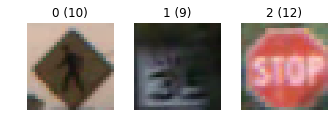

In [3]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

In [ ]:
graph = tf.Graph()

with graph.as_default():
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = keras.layers.Flatten()(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)
 
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))
    
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

In [ ]:
session = tf.Session(graph=graph)

_ = session.run([init])

labels_a = np.array(labels)
images_a = np.array(images32)

# shows how the training is progressing
for i in range(201):
    _, loss_value = session.run([train, loss], feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

In [ ]:
#-----------------------------------------------------------
# USING MODEL

In [ ]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(categories[truth], categories[prediction]), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

In [ ]:
#------------------------------------------------------ 
# EVALUATION

In [ ]:
test_images, test_labels = load_data(test_data_dir, anno_dir)

# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [ ]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

In [35]:
# Close the session. This will destroy the trained model.
session.close()